In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
base = pd.read_csv('poluicao.csv')
base = base.dropna()
base.head(3)

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0


In [7]:
base.tail(3)

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0
43823,43824,2014,12,31,23,12.0,-21,-3.0,1034.0,NW,249.85,0,0


In [10]:
columns = ['No', 'year', 'month', 'day', 'hour', 'cbwd']
base = base.drop(columns, 1)

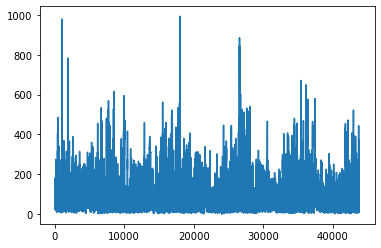

In [11]:
plt.plot(base['pm2.5'])

In [14]:
base = base.dropna().reset_index(drop=True)
base.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
0,129.0,-16,-4.0,1020.0,1.79,0,0
1,148.0,-15,-4.0,1020.0,2.68,0,0
2,159.0,-11,-5.0,1021.0,3.57,0,0
3,181.0,-7,-5.0,1022.0,5.36,1,0
4,138.0,-7,-5.0,1022.0,6.25,2,0


In [15]:
base.shape

(41757, 7)

In [17]:
import math
index_test = math.ceil(41757*0.8)
index_test

33406

In [18]:
base_treinamento = base.iloc[:index_test, 0:7].values

In [19]:
normalizador = MinMaxScaler(feature_range=(0,1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)

In [32]:
normalizador_previsao = MinMaxScaler(feature_range=(0,1))
normalizador_previsao.fit_transform(base_treinamento[:,0:1])

array([[0.12977867],
       [0.14889336],
       [0.15995976],
       ...,
       [0.25150905],
       [0.15995976],
       [0.12474849]])

In [20]:
base_treinamento_normalizada.shape

(33406, 7)

In [22]:
timesteps = 10

In [23]:
previsores = []
preco_real = []
for i in range(timesteps, len(base_treinamento_normalizada)):
    previsores.append(base_treinamento_normalizada[i-10:i, 0:7])
    preco_real.append(base_treinamento_normalizada[i, 0])
previsores, preco_real = np.array(previsores), np.array(preco_real)
previsores.shape

(33396, 10, 7)

In [24]:
regressor = Sequential()
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (previsores.shape[1], 7)))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.3))

regressor.add(Dense(units = 1, activation = 'sigmoid'))

regressor.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics = ['mean_absolute_error'])

regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 100)           43200     
_________________________________________________________________
dropout (Dropout)            (None, 10, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 50)            30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [25]:
regressor.fit(previsores, preco_real, epochs = 100, batch_size = 32)

Epoch 1/100
1044/1044 [==============================] - 26s 25ms/step - loss: 0.0045 - mean_absolute_error: 0.0449
Epoch 2/100
1044/1044 [==============================] - 25s 24ms/step - loss: 0.0014 - mean_absolute_error: 0.0259
Epoch 3/100
1044/1044 [==============================] - 25s 24ms/step - loss: 0.0011 - mean_absolute_error: 0.0220
Epoch 4/100
1044/1044 [==============================] - 24s 23ms/step - loss: 9.5905e-04 - mean_absolute_error: 0.0206 0s - loss: 9.5883e-04 - mean_absolute_erro
Epoch 5/100
1044/1044 [==============================] - 26s 25ms/step - loss: 8.9805e-04 - mean_absolute_error: 0.0196
Epoch 6/100
1044/1044 [==============================] - 25s 24ms/step - loss: 8.5112e-04 - mean_absolute_error: 0.0190
Epoch 7/100
1044/1044 [==============================] - 25s 24ms/step - loss: 8.1722e-04 - mean_absolute_error: 0.0185
Epoch 8/100
1044/1044 [==============================] - 24s 23ms/step - loss: 8.0777e-04 - mean_absolute_error: 0.0181
Epoch 9/1

In [26]:
preco_real_teste = base.iloc[index_test:, 0:1].values

In [27]:
entradas = base[index_test - timesteps:].values
entradas = normalizador.transform(entradas)

In [28]:
entradas.shape

(8361, 7)

In [29]:
X_teste = []
for i in range(timesteps, len(entradas)):
    X_teste.append(entradas[i-timesteps:i, 0:7])
X_teste = np.array(X_teste)
X_teste.shape

(8351, 10, 7)

In [33]:
previsoes = regressor.predict(X_teste)
previsoes = normalizador_previsao.inverse_transform(previsoes)
previsoes.shape

(8351, 1)

In [34]:
print(previsoes.mean())
print(preco_real_teste.mean())

95.52174
97.75308346305832


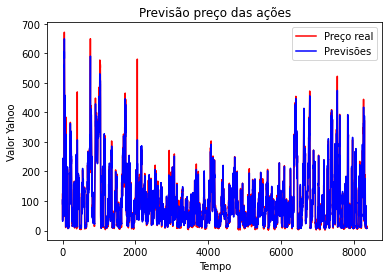

In [54]:
plt.plot(preco_real_teste, color = 'red', label = 'Preço real')
plt.plot(previsoes, color = 'blue', label = 'Previsões')
plt.title('Previsão preço das ações')
plt.xlabel('Tempo')
plt.ylabel('Valor Yahoo')
plt.legend()
plt.show()

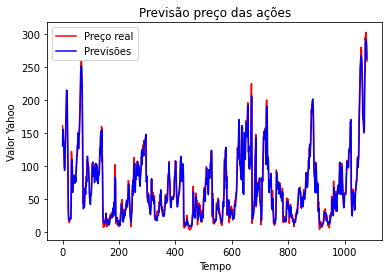

In [55]:
inicio = 3000
fim = inicio + 1080
plt.plot(preco_real_teste[inicio:fim], color = 'red', label = 'Preço real')
plt.plot(previsoes[inicio:fim], color = 'blue', label = 'Previsões')
plt.title('Previsão preço das ações')
plt.xlabel('Tempo')
plt.ylabel('Valor Yahoo')
plt.legend()
plt.show()